# SLTimer Analysis on TDC2 Data

This notebook shows the analysis on TDC2 data with the use of SLTimer. We try to explore PyCS code to understand what combination of parameter could be best to make PyCS fit data well. 
Two parameters we could tune are knotstep for micro-lensing spline function and knotstep for spline function used to fit intrinsic variability of light curve (will be called intrinsic light curve hereafter). To simplify the analysis, we set the knotstep for micro-lensing spline function to 350 days, because micro-lensing effect does not likely make quasar lightcurve have variability within a year. With the above concern, in this notebook, we try to understand which knotstep parameter we should choose for intrinsic spline function to get a good fit and how do the parameter we choosed affect the recovered time-delay. 
In this notebook, we first do the analysis on all the data. We then do the same analysis with i-band data only, because one possible extra noise comes from the different gain in each bands. 

##  All data analysis

First, we'll import `SLTimer`, as well as a few other important commands. 

In [1]:
from __future__ import print_function
import os, urllib, numpy as np
%matplotlib inline
import desc.sltimer

%load_ext autoreload
%autoreload 2

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/__init__.py:1155: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Data Munging and SLTimer Setup

Start a timer object, download some data to use, and plot the data. 

Downloaded datafile: http://www.slac.stanford.edu/~pjm/LSST/DESC/SLTimeDelayChallenge/release/tdc2/gateway/tdc2-gateway-1.txt
Checking header of "tdc2-gateway-1.txt"...
Reading "tdc2-gateway-1.txt"...
[Image/A] with 1006 points imported (0 of them masked).
Checking header of "tdc2-gateway-1.txt"...
Reading "tdc2-gateway-1.txt"...
[Image/B] with 1006 points imported (0 of them masked).


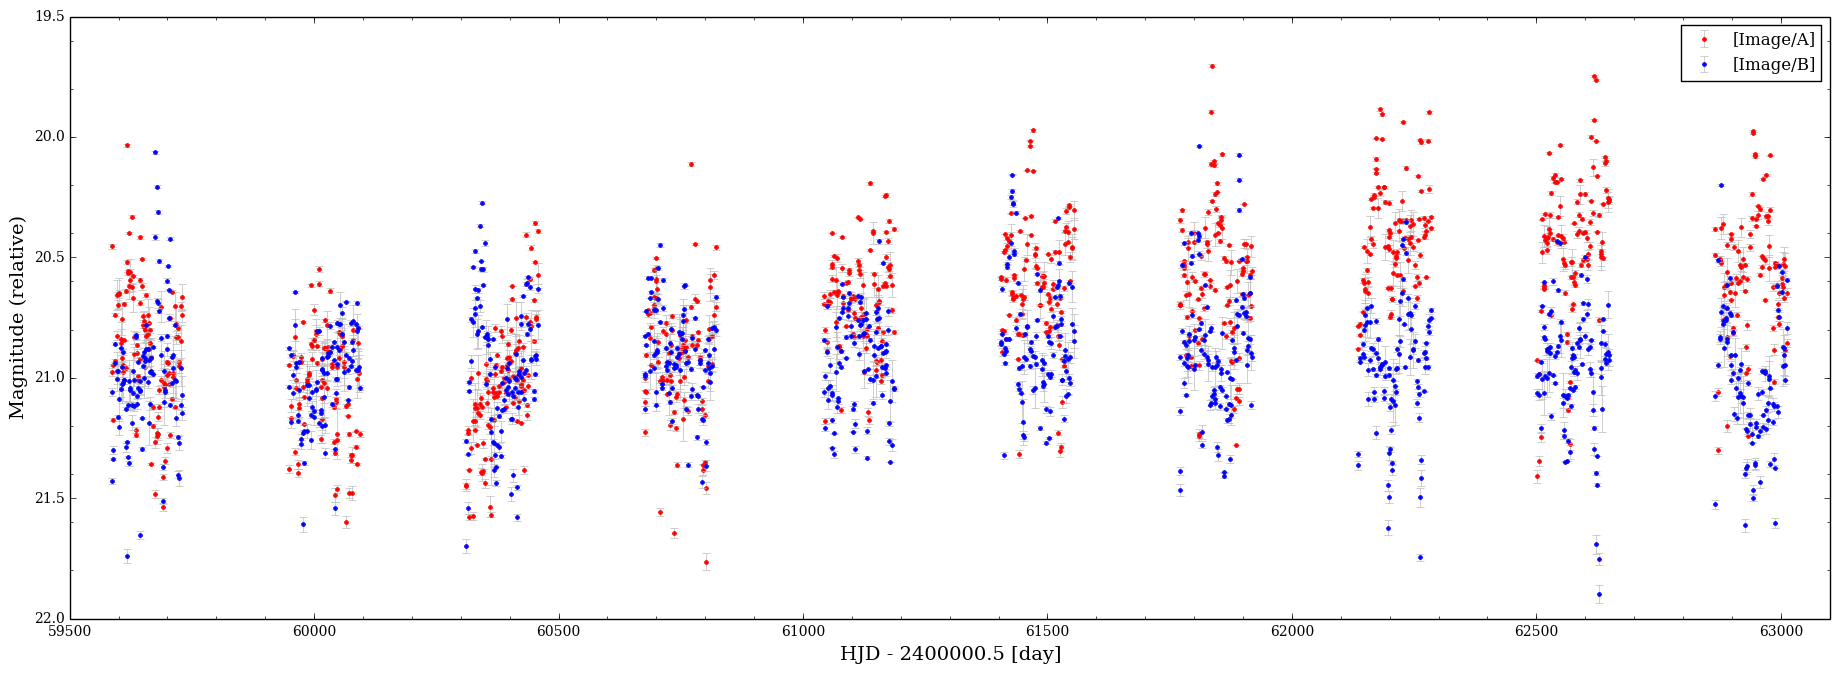

In [2]:
timer = desc.sltimer.SLTimer()
url = "http://www.slac.stanford.edu/~pjm/LSST/DESC/SLTimeDelayChallenge/release/tdc2/gateway/tdc2-gateway-1.txt"
timer.download(url, and_read=True, format='tdc2')
timer.display_light_curves(jdrange=(59500,63100))

We'll need the true time delays to compare our results to:

In [3]:
truthurl = "http://www.slac.stanford.edu/~pjm/LSST/DESC/SLTimeDelayChallenge/release/tdc2/gateway/gatewaytruth.txt"
truthfile = truthurl.split('/')[-1]
if not os.path.isfile(truthfile):
    urllib.urlretrieve(truthurl, truthfile)
d = np.loadtxt(truthfile).transpose()
truth = d[0]
print("True Time Delays:", truth)

True Time Delays: [  55.37   39.1    46.7    24.06   97.19   52.2    50.72  111.49  117.69
   40.56]


We offset the light curves to a common mean to get a set of points that look more like they were taken in one filter.

In [4]:
timer.whiten()

whiten: before whitening, means = {'A': 20.709889147670161, 'B': 20.94298685962023}
whiten: before whitening, scatters = {'A': 0.33118712223926861, 'B': 0.24520912405242912}
whiten: detected bands: ['g' 'i' 'r' 'u' 'y' 'z']
whiten: after whitening, means = {'A': 20.709889147670133, 'B': 20.942986859620206}
whiten: after whitening, scatters = {'A': 0.32647791567919038, 'B': 0.24278378000885817}


We set knotsteps of micro lensing spline function to 350 because we think micro lensing should not vary very fast. 

In [5]:
timer.ml_knotstep=350

## Data Analysis

We're now ready to analyze this data. 

In the following code, we are generating the chisquare-time delay diagram for different knotstep.  

For each run, we change the knotstep parameter for intrinsic spline function. We then generate the chisquare-time delay diagram by regularly sampling time-delay from -120 days to 120 days. For each sample, we shift the curve accordingly, use free spline function to fit the light curve (at the constant time delay), and compute the chisquare. The way we fit the quasar has  three stages, which are:
```python
pycs.spl.topopt.opt_rough(nit=5, knotstep=2.5*knotstep) 
pycs.spl.topopt.opt_rough(nit=5, knotstep=1.5*knotstep)
pycs.spl.topopt.opt_fine(nit=10, knotstep=knotstep)
```

In [6]:
out_dir="./"
def Run(knotstep):
    nsample=1000
    sample=np.linspace(-120,120,nsample).reshape(-1,1)
    timer.knotstep=knotstep
    timer.compute_likelihood_simpleMC(nsample=nsample, nprocess=2,
                                    rangeList=None, outName=out_dir+"test_nolensing_notsStep{0}".format(knotstep),
                                    save_file=True, samples=sample)

In [7]:
# Run(20)
# This function will generate a file with the first column be time-delay and second column be chisquare. 
# However since the process will take about an hour to run, I suggest you to download the files I've already generated

The link to the files I generated with Run function:

In [8]:
SampleUrl="http://stanford.edu/~chto/SLTimer_TDC2_sample/lensing_350_all/"
name_data="ml350_all_{0}_delay_chi2_1000_samples.txt"

Define functions to download and plot files:

In [9]:
import os, urllib
def getFile(knotstep):
    name=name_data.format(knotstep)
    url=SampleUrl+name
    urllib.urlretrieve(url, name)
def plot_file(timer, knotstep):
    name=name_data.format(knotstep)
    print(name)
    timer.plot_likelihood_from_file(name, outName="", chisquare=True, bins=200,corner_plot=False)

Define the function to plot chisquare-time delay diagram at a given knotstep and also print out degree of freedom and number of data:

In [10]:
def batch_analyze(timer, knotstep):
    timer.knotstep=knotstep
    timer.ml_knotstep=350
    getFile(knotstep)
    plot_file(timer, knotstep)
    print("degree of freedom is : {0}".format(timer.degree_of_freedom()))

Define the function to plot light curve given a time delay:

In [11]:
def plot_light_curve(timer, delay, knotstep):
    timer.knotstep=knotstep
    lcs, agn = timer.compute_chisq(delay=[delay], getlcs=True)
    timer.display_light_curves(given_curve=(lcs,agn))

### 1. Knotstep=20

Plot chisquare as a function of time delay, when the intrinsic spline model knotstep parameter = 20:

ml350_all_20_delay_chi2_1000_samples.txt
Starting ML optimization ...
Done !
Starting ML optimization ...
Done !
knotstep for intrinsic fluctuation is: 20
knotstep for micro lensing is: 350
number of data points is: 2012
degree of freedom is : {'dof': 1516, '# data': 2012}


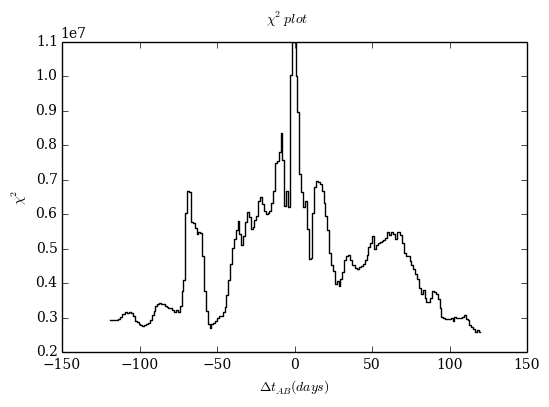

In [12]:
batch_analyze(timer, knotstep=20)

> Note:
>
The minimum chisquare is around `0.2*1e7` and number of data is 2012, which means that on average the fitted curve is `(0.2*1e7/2012)**(1/2)` = 31.5 sigma away from the data. 

Plot the fitted curve and data at true time delay (ie delay=55):

Starting ML optimization ...
Working on the spline ML of [Image/A]|~3/u/8~|
Working on the spline ML of [Image/B](-55.000,-0.249,0)|~3/u/8~|
Done !
Starting ML optimization ...
Working on the spline ML of [Image/A]|~3/u/8~|
Working on the spline ML of [Image/B](-55.000,-0.249,0)|~3/u/8~|
Done !


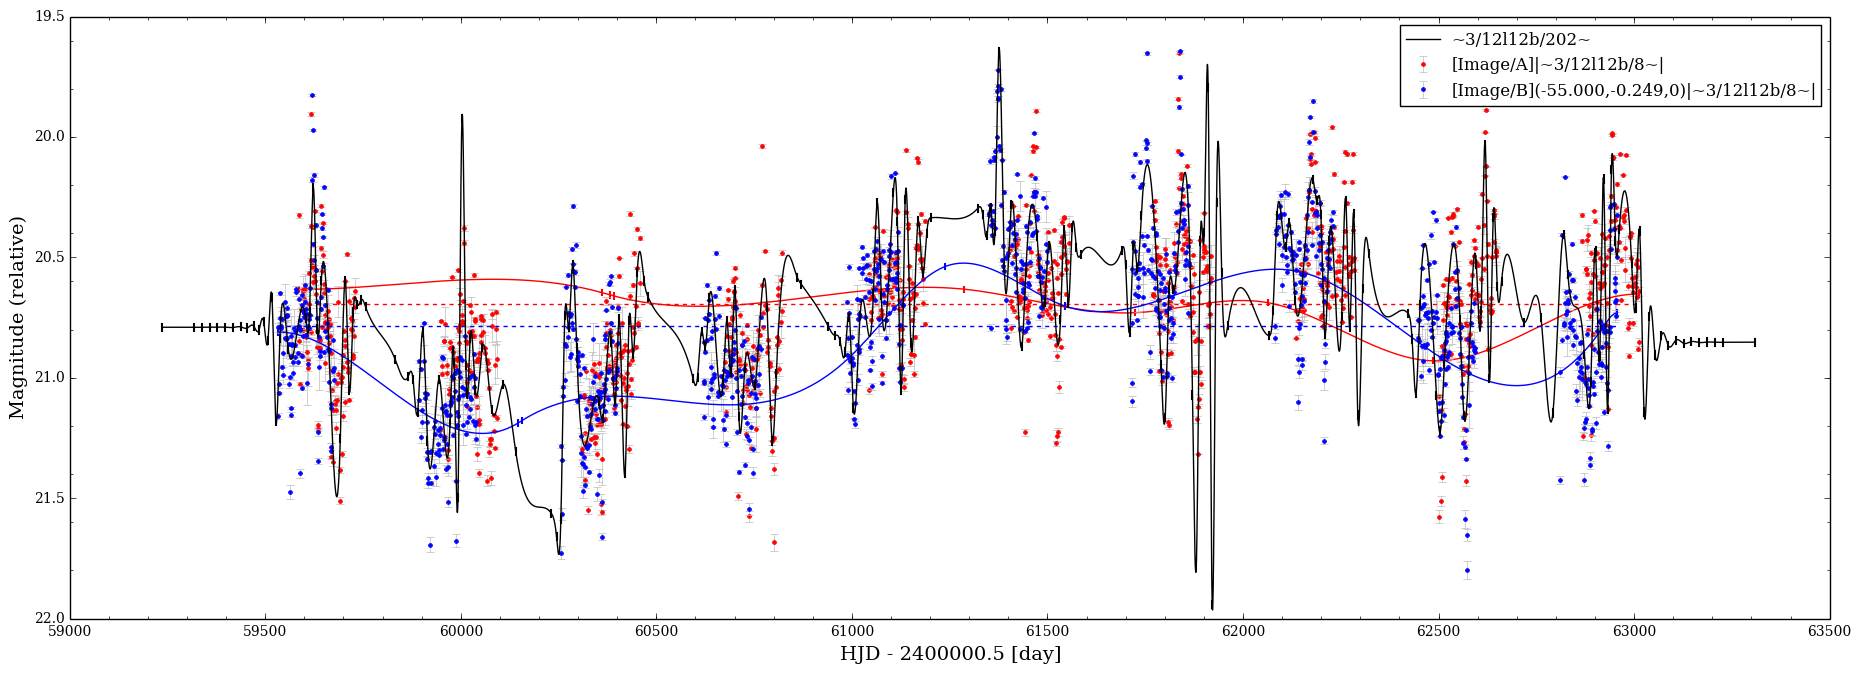

In [13]:
plot_light_curve(timer, delay=-55, knotstep=20)

Let's now repeat the above analysis with knotstep=50, and then knotstep=70.

> Note: Here, I only show 50 and 70 to demostrate, but I have done the analysis with knotstep = 20, 30, 40, 50, 60, 70, 80, 90, 100. 

### 2. Knotstep=50

ml350_all_50_delay_chi2_1000_samples.txt
Starting ML optimization ...
Done !
Starting ML optimization ...
Done !
knotstep for intrinsic fluctuation is: 50
knotstep for micro lensing is: 350
number of data points is: 2012
degree of freedom is : {'dof': 1756, '# data': 2012}


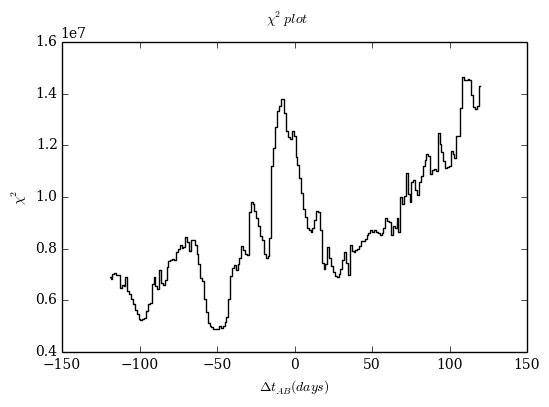

In [14]:
batch_analyze(timer, knotstep=50)

Starting ML optimization ...
Working on the spline ML of [Image/A]|~3/u/8~|
Working on the spline ML of [Image/B](-55.000,-0.249,0)|~3/u/8~|
Done !
Starting ML optimization ...
Working on the spline ML of [Image/A]|~3/u/8~|
Working on the spline ML of [Image/B](-55.000,-0.249,0)|~3/u/8~|
Done !


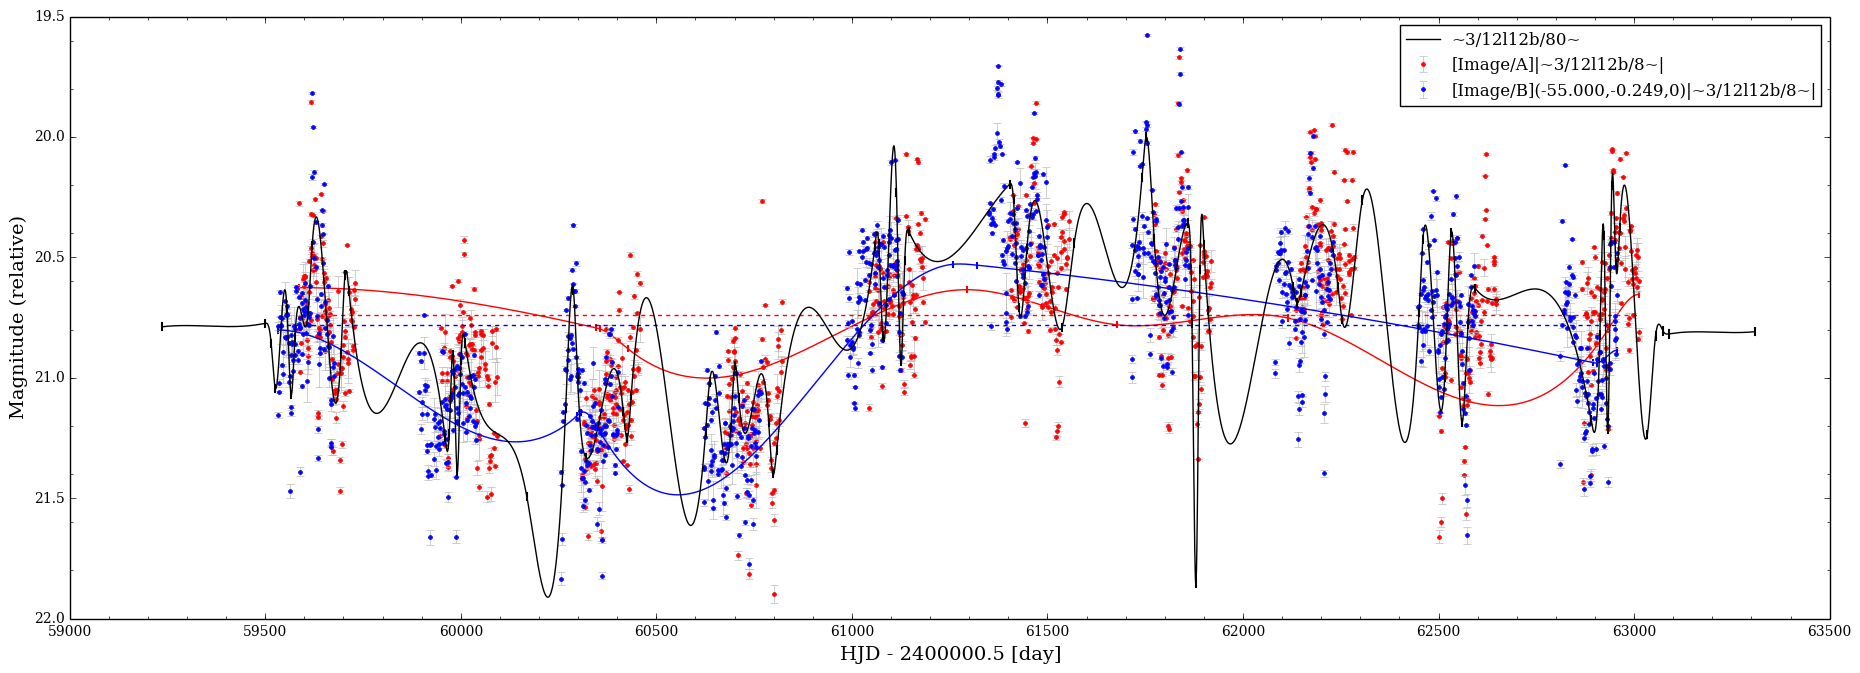

In [17]:
plot_light_curve(timer, delay=-55, knotstep=50)

### 3. Knotstep=70

ml350_all_70_delay_chi2_1000_samples.txt
Starting ML optimization ...
Done !
Starting ML optimization ...
Done !
knotstep for intrinsic fluctuation is: 70
knotstep for micro lensing is: 350
number of data points is: 2012
degree of freedom is : {'dof': 1800, '# data': 2012}


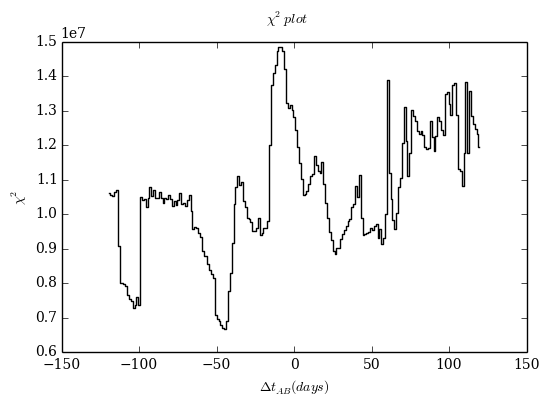

In [16]:
batch_analyze(timer, 70)

Starting ML optimization ...
Working on the spline ML of [Image/A]|~3/u/8~|
Working on the spline ML of [Image/B](-55.000,-0.249,0)|~3/u/8~|
Done !
Starting ML optimization ...
Working on the spline ML of [Image/A]|~3/u/8~|
Working on the spline ML of [Image/B](-55.000,-0.249,0)|~3/u/8~|
Done !


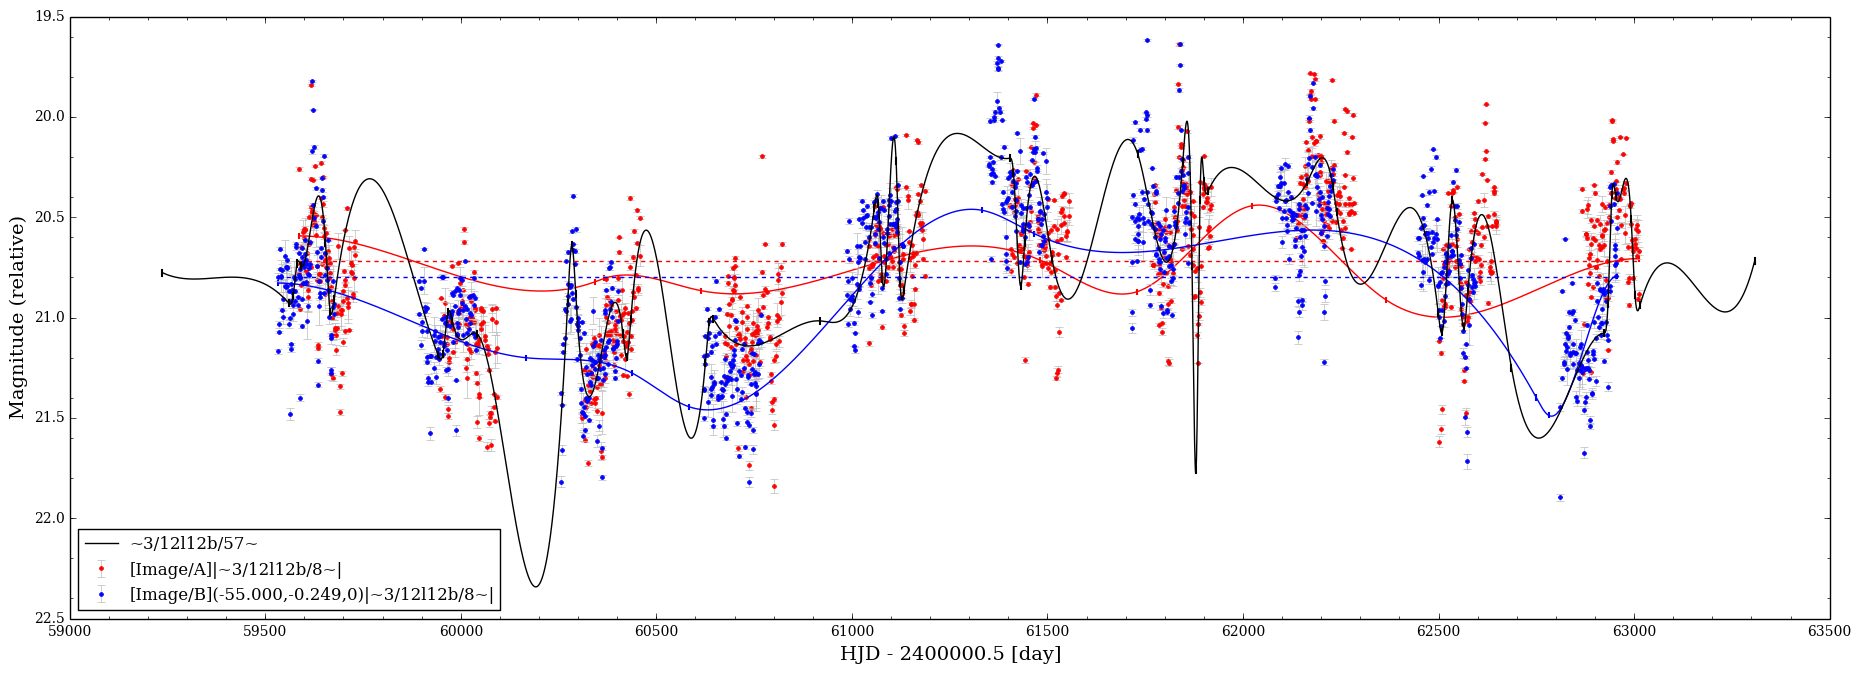

In [15]:
plot_light_curve(timer, -55, 70)

>Notes:
>
The above analysis of the whitened TDC2 gateway 1 datasets shows that there are lots of local chi-squared minima, as predicted by Malte and Vivien. It also shows that the goodness of fit is very low, even at the minima in chi-squared.
>
One possible source of the poor quality fit is that the whitening may have left some residual structure in the light curve. To check this, and simplify the problem, in the following section, I'll perfom the same analysis on just the $i$-band data alone. 

## i band data analysis

Downloaded datafile: http://www.slac.stanford.edu/~pjm/LSST/DESC/SLTimeDelayChallenge/release/tdc2/gateway/tdc2-gateway-1.txt
Checking header of "tdc2-gateway-1.txt"...
Reading "tdc2-gateway-1.txt"...
[Image/A] with 1006 points imported (0 of them masked).
Checking header of "tdc2-gateway-1.txt"...
Reading "tdc2-gateway-1.txt"...
[Image/B] with 1006 points imported (0 of them masked).
Keep only bands i


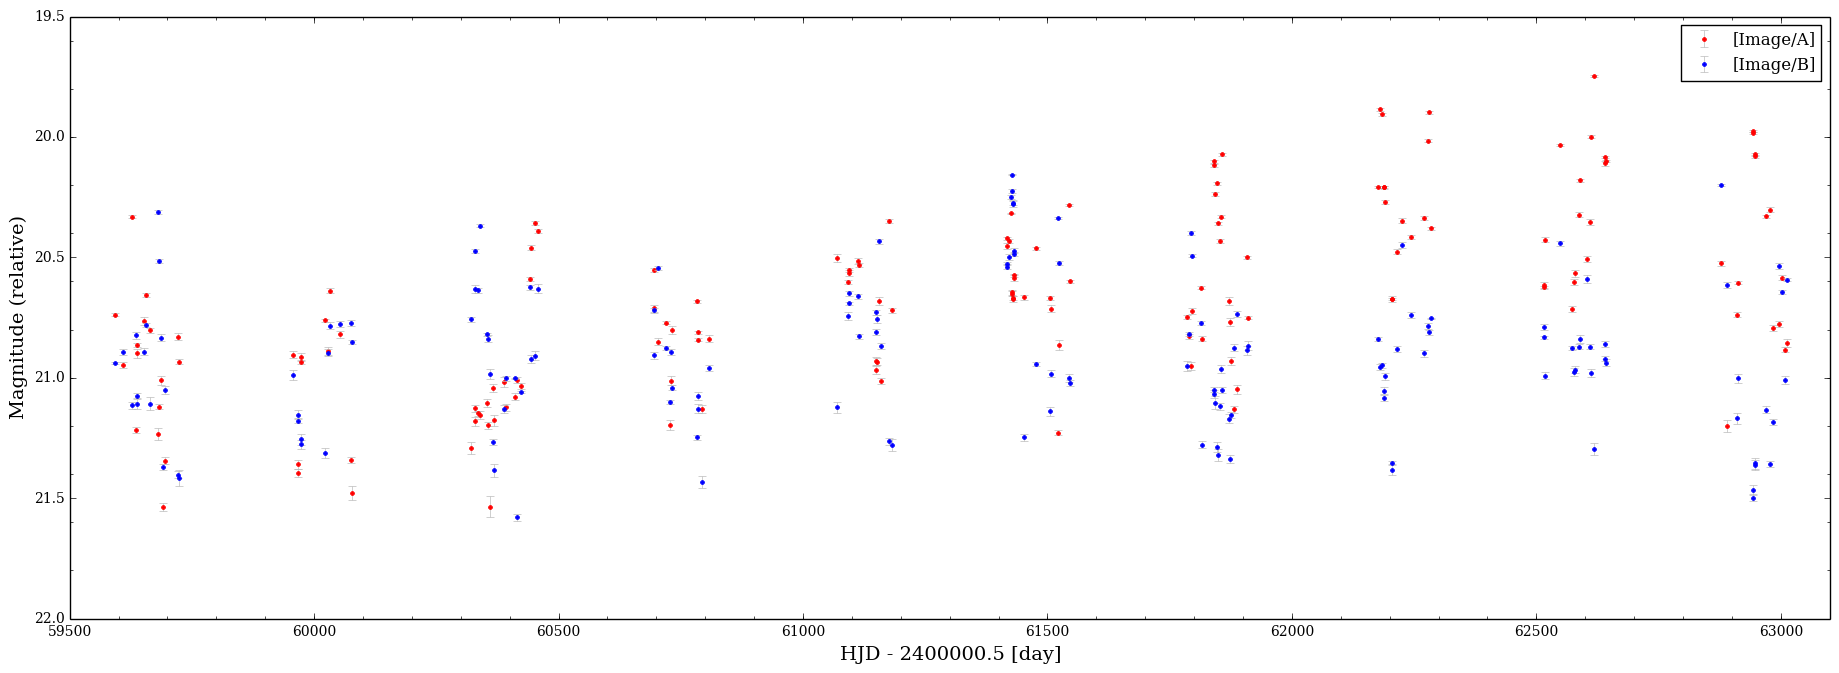

In [18]:
timer_i = desc.sltimer.SLTimer()
url = "http://www.slac.stanford.edu/~pjm/LSST/DESC/SLTimeDelayChallenge/release/tdc2/gateway/tdc2-gateway-1.txt"
timer_i.download(url, and_read=True, format='tdc2')
timer_i.select_bands('i')
timer_i.display_light_curves(jdrange=(59500,63100))
name_data="ml350_i_{0}_delay_chi2_1000_samples.txt"
SampleUrl="http://stanford.edu/~chto/SLTimer_TDC2_sample/lensing_350_iband/"

In [19]:
timer_i.ml_knotstep=350

### 1. Knotstep=20

ml350_i_20_delay_chi2_1000_samples.txt
Starting ML optimization ...
Done !
Starting ML optimization ...
Done !
knotstep for intrinsic fluctuation is: 20
knotstep for micro lensing is: 350
number of data points is: 312
degree of freedom is : {'dof': -184, '# data': 312}


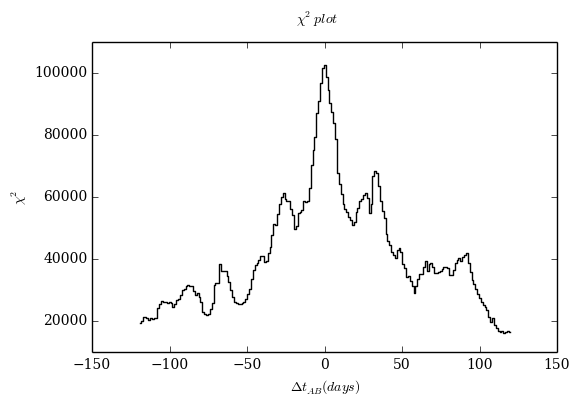

In [20]:
batch_analyze(timer_i, knotstep=20)

In [16]:
plot_light_curve(timer_i, delay=-55, knotstep=20)

NameError: name 'timer_i' is not defined

### 2. Knotstep=50

ml350_i_50_delay_chi2_1000_samples.txt
Starting ML optimization ...
Done !
Starting ML optimization ...
Done !
knotstep for intrinsic fluctuation is: 50
knotstep for micro lensing is: 350
number of data points is: 312
degree of freedom is : {'dof': 56, '# data': 312}


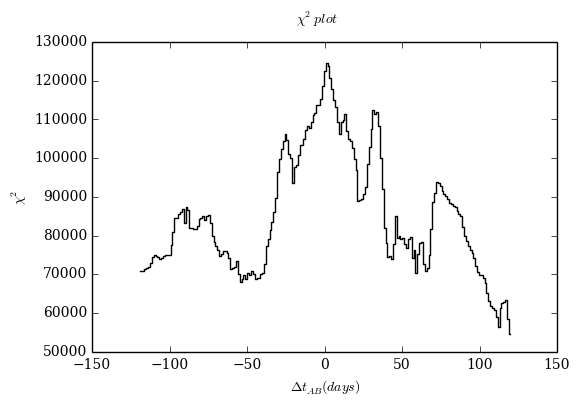

In [22]:
batch_analyze(timer_i, knotstep=50)

In [ ]:
plot_light_curve(timer_i, delay=-55, knotstep=50)

### 3. Knotstep=70

ml350_i_70_delay_chi2_1000_samples.txt
Starting ML optimization ...
Done !
Starting ML optimization ...
Done !
knotstep for intrinsic fluctuation is: 70
knotstep for micro lensing is: 350
number of data points is: 312
degree of freedom is : {'dof': 100, '# data': 312}


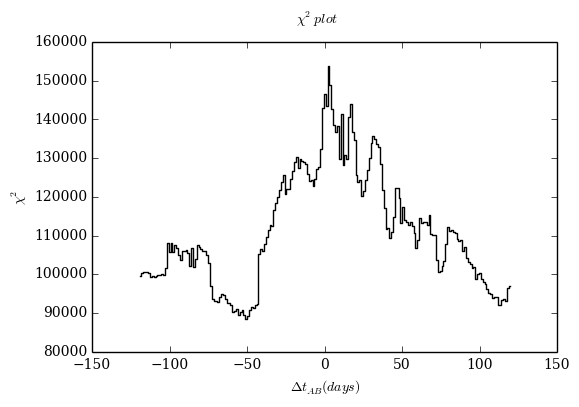

In [24]:
batch_analyze(timer_i, knotstep=70)

In [ ]:
plot_light_curve(timer_i, delay=-55, knotstep=70)

> Notes:
>
As you see, chi-squared goes very low at high time delay, no matter what knotsteps we put in. The reason for this is because for long time delay, the data will not overlap with each other, and so in the absence of any conflicting shifted datapoints, the spline function is better able to  fit the data. 
>
The chi-squared minimum at **-55** days seeems persistent, betweem whitened data and single-filter data. We need to check with Kai what the definition of the time delay is (B-A or A-B).
> 
The minimum chi-squared in the $i$-band only fit was about 20000 for 312 datapoints and knotstep=20, which corresponds to the model being, on average, `(20000/312)**(1/2) = 8` sigma away from data.

# Conclusions: 

**1** The fitted light curve seems not to be fitting the data at all well, given the value of minimum chisquare and number of data: the fitted curves seem to be many sigma away from the data. We think there are two possible reasons for this. 
  a) We just aren't finding the best spline and microlensing parameters for the fits, somehow. 
  b) The spline model is systematically under-fitting the data, due to the stochastic variability of the intrinsic AGN light curve on small timescales (or if you prefer, the error bars of the gateway data do not properly describe the extra "noise" associated with the rapidly-fluctuating quasar light curve). 

> A question for the PyCS developers regarding reason a): Are there better settings and strategies we could use, to improve our fits?

> To address possibility b), we might think of including an additional "intrinsic variance" parameter to the denominator of the chi-squared (and also to the normalization of the likelihood), and try to infer that as well as the time delay. It's a bit tricky, because the PyCS fits are done using the error bars stored in the `lcs` array - so really these would need to be adjusted at each point in parameter space.


**2** From our chisquared vs time delay plots, we found that there are lots of local minimum. Besides, the global minimum is not on the true answer, which suggests that it's going to be hard for PyCS to recover the true time delay from TDC2 data, reliably (or at least, not without manual intervention?). 

> Should we try and use Vivien's prediction method to help select a particular chi-squared minimum? 

> We are also planning to include the information from the lens model provided with the TDC2 light curves, in combination with a broad prior for the Hubble constant, to provide a prior PDF for the time delays. This would then be divided out when combining the results from many lenses, to avoid biasing the result by applying the H0 prior too many times. 

To sanity-check conclusion number 1, we can test the method on the `PyCS` tutorial light curve, and compare the mean chi-squared per datapoint there.

Downloaded datafile: https://raw.githubusercontent.com/COSMOGRAIL/PyCS/master/demo/demo1/data/trialcurves.txt
Checking header of "trialcurves.txt"...
Reading "trialcurves.txt"...
[Trial/A] with 192 points imported (0 of them masked).
Checking header of "trialcurves.txt"...
Reading "trialcurves.txt"...
[Trial/B] with 192 points imported (0 of them masked).
Checking header of "trialcurves.txt"...
Reading "trialcurves.txt"...
[Trial/C] with 192 points imported (0 of them masked).
Checking header of "trialcurves.txt"...
Reading "trialcurves.txt"...
[Trial/D] with 192 points imported (0 of them masked).


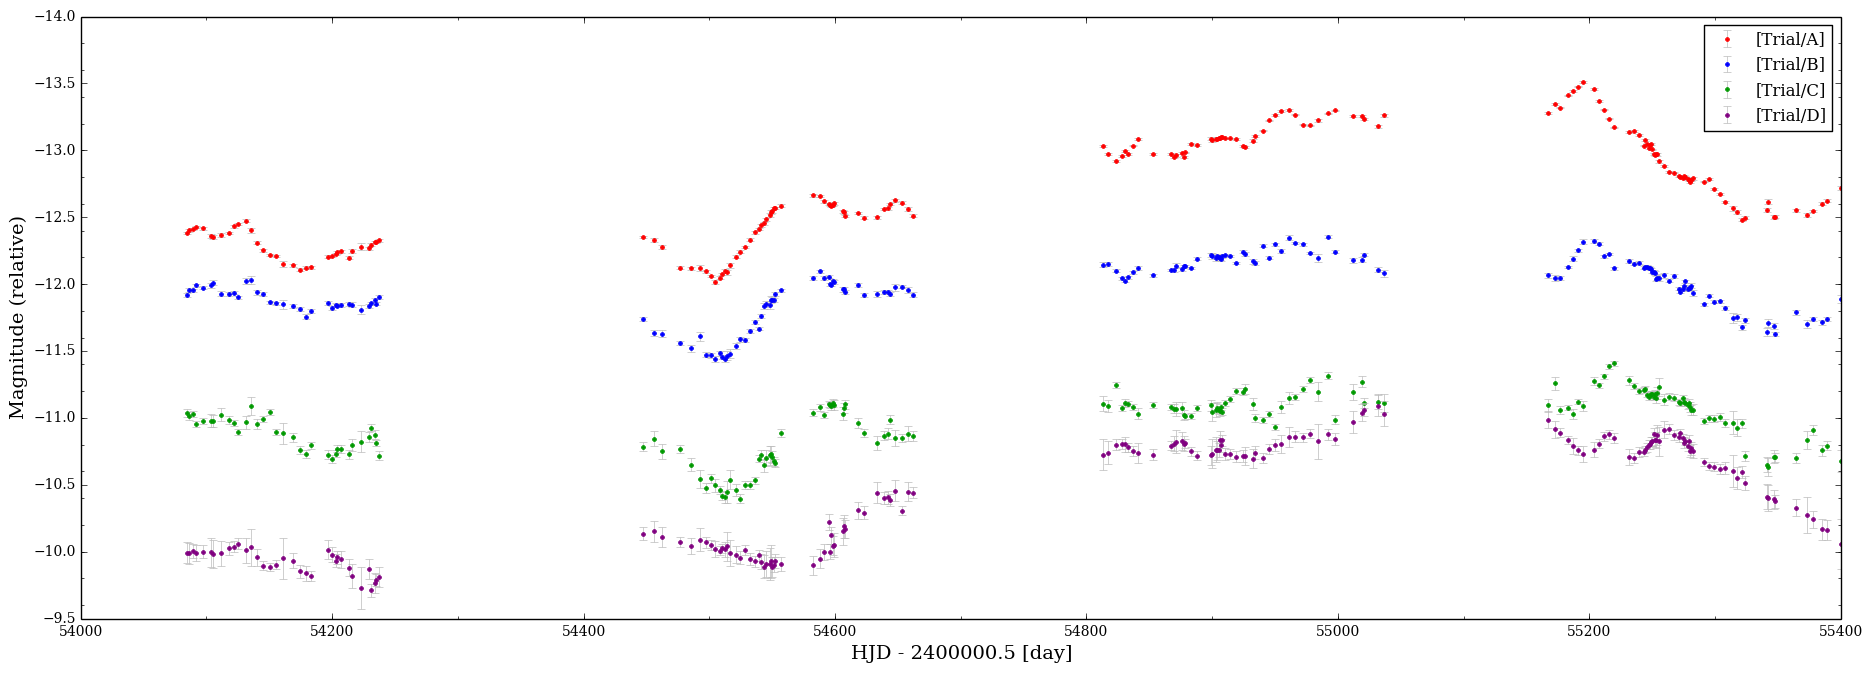

In [39]:
timer_tutorial = desc.sltimer.SLTimer()
url = "https://raw.githubusercontent.com/COSMOGRAIL/PyCS/master/demo/demo1/data/trialcurves.txt"
timer_tutorial.download(url, and_read=True)
timer_tutorial.display_light_curves()

In [40]:
timer_tutorial.ml_knotstep=150
timer_tutorial.knotstep=20
timer_tutorial.add_spline_microlensing()
timer_tutorial.optimize_spline_model()
timer_tutorial.degree_of_freedom()

Starting opt_rough on initial delays :
AB   +0.00 | AC   +0.00 | AD   +0.00 | BC   +0.00 | BD   +0.00 | CD   +0.00
Aiming at first curve.
Starting ML optimization ...
Working on the spline ML of [Trial/A]|~3/u/7~|
Working on the spline ML of [Trial/B](0.000,-0.647,0)|~3/u/7~|
Working on the spline ML of [Trial/C](0.000,-1.603,0)|~3/u/7~|
Working on the spline ML of [Trial/D](0.000,-2.092,0)|~3/u/7~|
Done !
First spline and ML opt done.
AB   -6.00 | AC  -13.00 | AD  -12.00 | BC   -7.00 | BD   -6.00 | CD   +1.00    (Iteration  1, r2 =  10248.2)
AB   -9.00 | AC  -19.00 | AD  -19.00 | BC  -10.00 | BD  -10.00 | CD   +0.00    (Iteration  2, r2 =  10029.2)
AB  -10.00 | AC  -21.00 | AD  -25.00 | BC  -11.00 | BD  -15.00 | CD   -4.00    (Iteration  3, r2 =   9855.9)
AB  -11.00 | AC  -22.00 | AD  -30.00 | BC  -11.00 | BD  -19.00 | CD   -8.00    (Iteration  4, r2 =   9749.2)
AB  -12.00 | AC  -23.00 | AD  -34.00 | BC  -11.00 | BD  -22.00 | CD  -11.00    (Iteration  5, r2 =   9679.4)
Rough time shif

{'# data': 768, 'dof': 384}

> We can see the chisquare for true answer is 2159.8, but the number of data is 768. The result implies that the fitted light curve is on average `(2159/768)**(1/2)` = 1.67 sigma away from the data. This is much more realistic (although still a slight underfit). This suggests that either we are not fitting the curves well enough yet, or the TDC2 data have higher intrinsic variance in them than the `PyCS` tutorial data.